# Data Analysis

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
dfTest = pd.read_csv("data/UJIndoorLoc_validationData.csv")

In [247]:
"""
    dfTrain.columns
    -------------------------------
    'WAP001', ..., 'WAP520', 
    'LONGITUDE', 'LATITUDE', 
    'FLOOR', 'BUILDINGID', 'SPACEID', 
    'RELATIVEPOSITION', 
    'USERID', 'PHONEID', 'TIMESTAMP'
    
    19937 rows, 529 columns
"""
print('\n- BUILDINGID')
display(dfTrain.BUILDINGID.value_counts())
print('\n- FLOOR')
display(dfTrain.FLOOR.value_counts())
print('\n- RELATIVEPOSITION')
display(dfTrain.RELATIVEPOSITION.value_counts())
print('\n- SPACEID')
display(dfTrain.SPACEID.nunique())
print('\n- PHONEID')
display(dfTrain.PHONEID.unique())
print('\n- USERID')
display(dfTrain.USERID.unique())
print('\n- Shape dfTrain')
dfTrain.shape


- BUILDINGID


2    9454
0    5248
1    5159
Name: BUILDINGID, dtype: int64


- FLOOR


3    5011
1    5001
2    4415
0    4332
4    1102
Name: FLOOR, dtype: int64


- RELATIVEPOSITION


2    16553
1     3308
Name: RELATIVEPOSITION, dtype: int64


- SPACEID


123


- PHONEID


array([23, 16, 18,  3, 19,  6,  1, 14,  8, 13, 24, 17,  7, 11, 22, 10],
      dtype=int64)


- USERID


array([ 2,  3,  4,  5,  6,  7,  8,  9, 16, 10, 11, 12, 13, 14, 15,  1, 17,
       18], dtype=int64)


- Shape dfTrain


(19861, 474)

## Deal not consistent data

In [185]:
"""
dfF = dfTrain[dfTrain.columns.values[0:520]]==100
dfF[dfF[dfTrain.columns.values[0:520]]==100].shape
#dfTrain.groupby('PHONEID').BUILDINGID.nunique() # nunique
"""
wifiSens = 520
dfTemp = dfTrain[dfTrain.columns.values[0:wifiSens]]

# drop columns (all rows in a column = 100, dont make any significance)
wa_columns = pd.DataFrame(dfTemp.sum(axis=0) == dfTrain.shape[0]*100, columns=['isOut'])
wa_columns = wa_columns[wa_columns['isOut']==False].T.columns.values
new_columns = list(wa_columns) + list(dfTrain.columns.values[wifiSens:])
dfTrain = dfTrain[new_columns]

# drop rows (all columns = 100 with different spaceId, buildingId, floorId)
dfTrain = dfTrain[dfTemp.sum(axis=1)  != wifiSens * 100]

dfTrain.shape

(19861, 474)

In [194]:
pd.crosstab(dfTrain.FLOOR, dfTrain.BUILDINGID)

BUILDINGID,0,1,2
FLOOR,,,
0,1058,1368,1906
1,1356,1484,2161
2,1443,1396,1576
3,1391,911,2709
4,0,0,1102


In [431]:
# FLOOR RELATIVEPOSITION
pd.DataFrame(pd.crosstab(dfTrain.SPACEID, [dfTrain.BUILDINGID, dfTrain.FLOOR]).sum(axis=0), columns=['SPACEID_COUNT']).T

BUILDINGID        0                       1                      2        \
FLOOR             0     1     2     3     0     1     2    3     0     1   
SPACEID_COUNT  1058  1356  1443  1391  1368  1484  1396  911  1906  2161   

BUILDINGID                       
FLOOR             2     3     4  
SPACEID_COUNT  1576  2709  1102

In [220]:
dfTrain.LONGITUDE.describe()

count    19861.000000
mean     -7464.366550
std        123.499669
min      -7691.338400
25%      -7594.737000
50%      -7423.060900
75%      -7359.193000
max      -7300.818990
Name: LONGITUDE, dtype: float64

In [221]:
dfTrain.LATITUDE.describe()

count    1.986100e+04
mean     4.864871e+06
std      6.695601e+01
min      4.864746e+06
25%      4.864821e+06
50%      4.864852e+06
75%      4.864930e+06
max      4.865017e+06
Name: LATITUDE, dtype: float64

In [242]:
building_0 = dfTrain.loc[(dfTrain.BUILDINGID == 0)]
display(building_0.SPACEID.nunique())
building_0 = dfTrain.loc[(dfTrain.BUILDINGID == 1)]
display(building_0.SPACEID.nunique())
building_0 = dfTrain.loc[(dfTrain.BUILDINGID == 2)]
display(building_0.SPACEID.nunique())

78

86

97

<IPython.core.display.Javascript object>


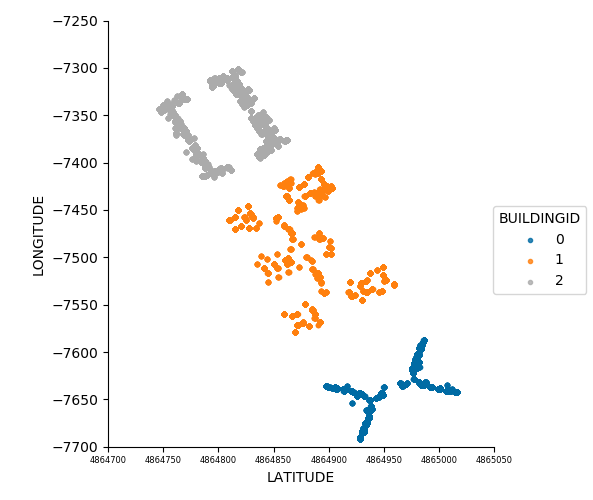

In [433]:
%matplotlib notebook
#g = sns.lmplot(x="LATITUDE", y="LONGITUDE", col="BUILDINGID", row="FLOOR", hue="SPACEID", data=dfTrain, fit_reg=False, x_jitter=.1)
sns.lmplot(x="LATITUDE", y="LONGITUDE", hue="BUILDINGID", data=dfTrain, fit_reg=False, x_jitter=.1, markers='.')
plt.show()


<IPython.core.display.Javascript object>


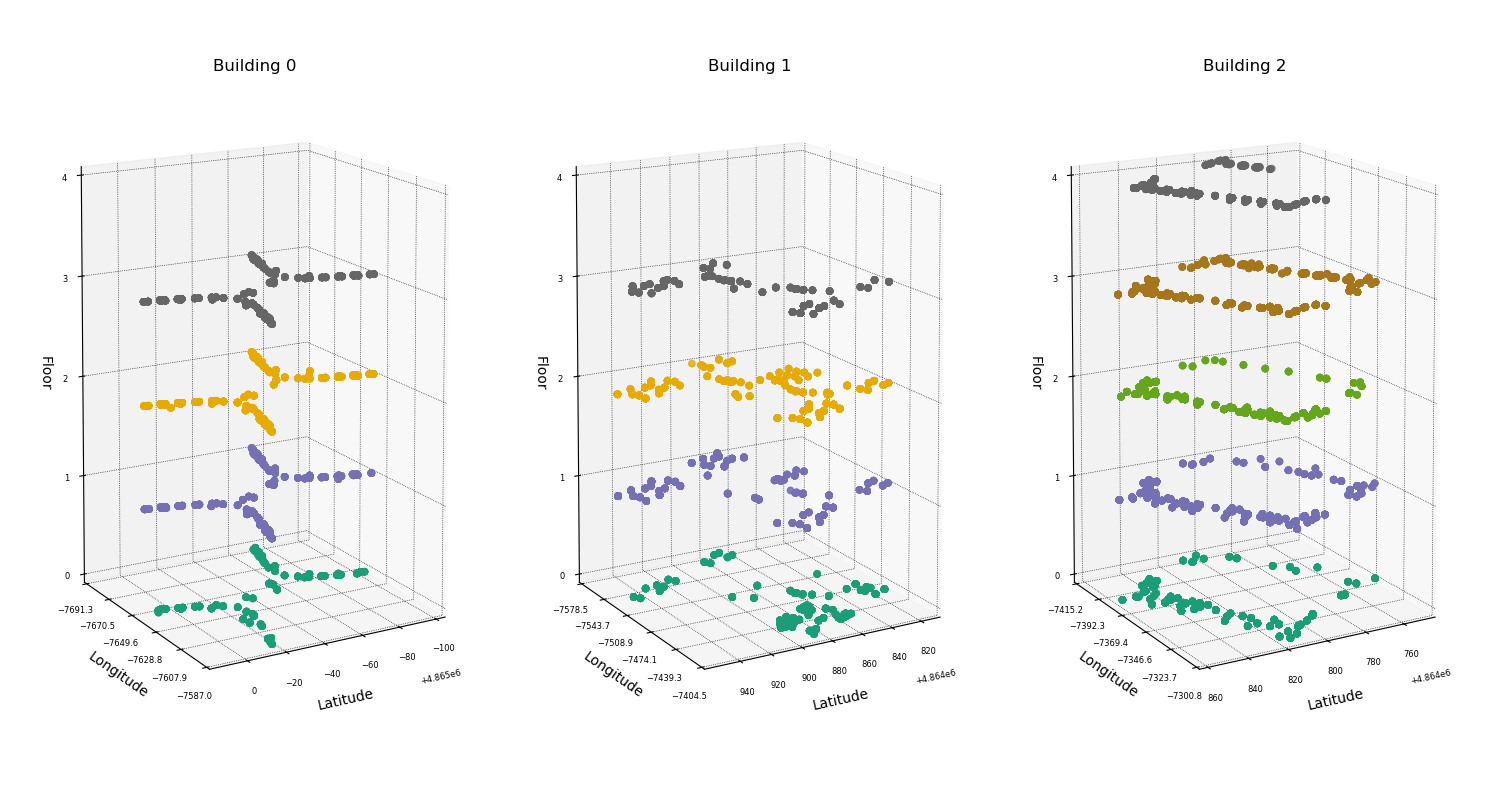

In [430]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker
import matplotlib as mpl

mpl.style.use('tableau-colorblind10')
mpl.rcParams['image.cmap'] = 'Dark2'
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
# mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

mpl.rcParams['xtick.labelsize'] = 6

fig = plt.figure(figsize=(15,8))
fig.tight_layout()
#import matplotlib.pyplot as plt

#ax = plt.axes(projection='3d')
#fig = plt.figure(figsize=plt.figaspect(0.5)) #
for index in range(3):
    ax = fig.add_subplot(1, 3, index+1, projection='3d')
    fig.tight_layout()
    #     ax.tick_params(axis='both', which='major', labelsize=10)
    #     ax.tick_params(axis='both', which='minor', labelsize=6)
    
    dfGraphics = dfTrain[dfTrain.BUILDINGID==index]
    x = dfGraphics.LATITUDE
    y = dfGraphics.LONGITUDE
    z = dfGraphics.FLOOR
    N = 6
    xmin = min(dfGraphics.LATITUDE)
    xmax = max(dfGraphics.LATITUDE)
    ymin = min(dfGraphics.LONGITUDE)
    ymax = max(dfGraphics.LONGITUDE)

    c = 10*dfGraphics.BUILDINGID + dfGraphics.FLOOR

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Floor')
    ax.set_title('Building '+str(index))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(0, 4)
    #ax.locator_params(axis='x', nbins=N)
    #ax.locator_params(axis='y', nbins=N)
    ax.set_yticks(np.round(np.linspace(ymin, ymax, N), 3))
    ax.set_xticks(np.round(np.linspace(xmin, xmax, N), 3))
    ax.set_zticks(np.int32(np.linspace(0, 4, 5)))
    ax.set_xscale('linear')
    #  ax.set_major_locator(mticker.MaxNLocator(nbins=9, steps=[1, 2, 5, 10]))
    ax.view_init(10, 60)
    ax.scatter(x, y, z, c=c)
    
    
    
plt.tight_layout()
plt.show()
plt.savefig("images/test.svg")

In [434]:
# Style sheets reference
# https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
# Style
# https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
# Color Maps
# https://matplotlib.org/tutorials/colors/colormaps.html
# Other References
# https://github.com/ohuarcaya/businessAnalytics/blob/master/compartamosFinanciera.ipynb
# https://es.stackoverflow.com/questions/163597/contar-cantidad-de-repeticiones-por-parejas-usando-pandas
# https://code.likeagirl.io/an%C3%A1lisis-y-visualizaci%C3%B3n-de-datos-con-pandas-matplotlib-85ee4d7b4cad

# https://matplotlib.org/gallery/pyplots/pyplot_scales.html
# https://seaborn.pydata.org/generated/seaborn.lmplot.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html

# Classification